In [438]:
'''
@title CHX-axis-labels-and-cropping
@author: Rebecca Coles
Updated on Aug 07, 2019

External CHX package:
    https://github.com/NSLS-II-CHX/pyCHX/blob/master/pyCHX/chx_xpcs_xsvs_jupyter_V1.py

Notes:
'''

# Import #######################################################################################
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import h5py
import itertools
from PIL import Image
import warnings
from scipy.ndimage.interpolation import rotate
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *
################################################################################################

# Package Settings #############################################################################
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
################################################################################################

# Variables ####################################################################################
y_crd = 1200 #horizontal cut at row
x_crd = 1100 #vertical cut at column 
x1, x2, y1, y2 = 900, 1650, 750, 1400 #crop image at given columns and rows
dpi = 80 #dpi of images
eiger_size_per_pixel = 0.075 #eiger is 75 um per pixel
################################################################################################

In [439]:
def save_hdf5(data, filename='data.h5', dataset='dataset'):
    ''' Access BlueSky HDF5 binary data from CHX measurement.
        
    :param data: HDF5 binary data from CHX measurement.
    :param filename='data.h5': HDF5 filename. Default is contained in the header file.
    :param dataset='dataset': Creates dataset type. Default is dataset.

    :return: string status of dataset creation
    '''
    h5f = h5py.File(filename, 'w')
    r = h5f.create_dataset(dataset, data=data)
    status = '{} created: {}'.format(r, os.path.abspath(filename))
    h5f.close()
    return status

In [440]:
def plot_profile_horiz(data, uid, y_crd, clim=(0, 200), cmap='afmhot', line_color='red', linestyles=None):
    ''' Show plot of intensity versus horizontal position.
        
    :param data: HDF5 binary data from CHX measurement.
    :param uid: unique ID automatically assigned to a CHX measurement.
    :param y_crd: add a horizontal line across the axis at a given location on the image.
    :param clim=(0, 200): sets the color limits of the current image.
    :param cmap='afmhot': color map (https://matplotlib.org/examples/color/colormaps_reference.html)
    :param line_color='red': color of line that will show the cut location.
    '''
    print("\n\nHorizontal cut at row " + str(y_crd))
        
    for d in data:
        plt.figure()
        plt.imshow(d, clim=clim, cmap=cmap)
        plt.axhline(y_crd, color=line_color)
        plt.show()

    plt.figure()
    warnings.filterwarnings("ignore")
    for i, d in enumerate(data):
        linestyle='-' if not linestyles else linestyles[i]
        plt.plot(np.log10(d[y_crd, :]), label=uid[i],
                linestyle=linestyle, linewidth=1)
    plt.grid()
    plt.legend()
    plt.show()

def plot_profile_vert(data, uid, x_crd, clim=(0, 200), cmap='afmhot', line_color='red', linestyles=None):
    ''' Show plot of intensity versus vertical position.
        
    :param data: HDF5 binary data from CHX measurement.
    :param uid: unique ID automatically assigned to a CHX measurement.
    :param x_crd: 
    :param clim=(0, 200): sets the color limits of the current image.
    :param cmap='afmhot': color map (https://matplotlib.org/examples/color/colormaps_reference.html) 
    :param line_color='red': 
    :param linestyles=None: 
    '''
    print("\n\nVertical cut at column " + str(x_crd))
    
    for d in data:
        plt.figure()
        plt.imshow(d, clim=clim, cmap=cmap)
        plt.axvline(x_crd, color=line_color)
        plt.show()

    plt.figure()
    warnings.filterwarnings("ignore")
    for i, d in enumerate(data):
        linestyle='-' if not linestyles else linestyles[i]
        plt.plot(np.log10(d[:, x_crd]), label=uid[i],
                linestyle=linestyle, linewidth=1)
    plt.grid()
    plt.legend()
    plt.show()

In [441]:
def display_image_in_actual_size(im, uid, clim, cmap='gist_stern'):
    ''' Display CHX eiger image in full size. Will save the plot as a TIFF.
        
    :param im: eiger detector image.
    :param uid: unique ID automatically assigned to a CHX measurement.
    :param cmap='gist_stern': color map (https://matplotlib.org/examples/color/colormaps_reference.html) 
    :param clim: sets the color limits of the current image.
    '''
    im_data = im
    height, width = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Title
    plt.title("UID: " + str(uid), fontsize=30)

    # Set up pixel axis
    ax.axis('on')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Pixels', fontsize=20)
    plt.ylabel('Pixels', fontsize=20)
    
    # Set up microm axis
    ax1 = ax.twiny() #Create a twin Axes sharing the yaxis
    ax2 = ax.twinx() #Create a twin Axes sharing the xaxis
    
    # Decide the ticklabel position in the new axis,
    # then convert them to the position in the old axis
    newlabelX = range(0,int(eiger_size_per_pixel*width),5) # labels of the ticklabels: the position in the new x-axis
    newlabelY = range(0,int(eiger_size_per_pixel*height),5) # labels of the ticklabels: the position in the new x-axis
    pixel2micronX = lambda width: width*eiger_size_per_pixel# convert function X: from pixels to microns
    pixel2micronY = lambda height: height*eiger_size_per_pixel # convert function Y: from pixels to microns
    newposX   = [pixel2micronX(width) for width in newlabelX]   # position of the xticklabels in the old x-axis
    newposY   = [pixel2micronY(height) for height in newlabelY]   # position of the yticklabels in the old y-axis
    
    ax1.set_xticks(newposX)
    ax1.set_xticklabels(newlabelY) 
    ax1.tick_params(axis="x", labelsize=20)
    
    ax2.set_yticks(newposY)
    ax2.set_yticklabels(newlabelY)
    ax2.tick_params(axis="y", labelsize=20)
    
    ax1.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2.yaxis.set_ticks_position('left') # set the position of the second y-axis to left
    
    ax1.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2.yaxis.set_label_position('left') # set the position of the second y-axis to left
    
    ax1.spines['bottom'].set_position(('outward', 80))
    ax2.spines['left'].set_position(('outward', 130))
    
    ax1.set_xlabel('mm', fontsize=20)
    ax2.set_ylabel('mm', fontsize=20)
    
    # Display the image.
    ax.imshow(im_data, cmap=cmap, clim=clim)
    
    # Save plot
    plt.savefig(str(uid) + ".tif", bbox_inches='tight')
    
    plt.draw()
    plt.show()

In [442]:
def display_cropped_image(im, uid, x1, x2, y1, y2, clim, cmap='gist_stern'):
    '''Display CHX eiger image cropped to user specifications. Will save the plot as a TIFF. 
        
    :param im: eiger detector image. 
    :param uid: unique ID automatically assigned to a CHX measurement.
    :param x1: x-axis stating location (columns)
    :param x2: x-axis final location (columns) 
    :param y1: y-axis stating location (rows) 
    :param y2: y-axis final location (rows)  
    :param cmap='gist_stern': color map (https://matplotlib.org/examples/color/colormaps_reference.html) 
    :param clim: sets the color limits of the current image.
    '''
    im_data = im
    height, width = im_data.shape
    croppedBoxHeight, croppedBoxWidth = x2-x1, y2-y1
    pixelTickMarkStepSize = 100
    
    # Crop the image from the center of the image
    im_data = im[x1:x2, y1:y2]

    # What size does the figure need to be in inches to fit the image?
    figsize = croppedBoxWidth / float(dpi), croppedBoxHeight / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    
    # Title
    plt.title("UID: " + str(uid) + "  Cropped: " + str(croppedBoxWidth) + "x" + str(croppedBoxHeight), fontsize=15)

    # Set up pixel axis
    ax.axis('on')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Pixels', fontsize=15)
    plt.ylabel('Pixels', fontsize=15)
    ax.set_xticks(range(0, croppedBoxHeight+pixelTickMarkStepSize, pixelTickMarkStepSize))
    ax.set_yticks(range(0, croppedBoxWidth+pixelTickMarkStepSize, pixelTickMarkStepSize))
    ax.set_xticklabels(range(x1, x2+pixelTickMarkStepSize, pixelTickMarkStepSize))
    ax.set_yticklabels(range(y1, y2+pixelTickMarkStepSize, pixelTickMarkStepSize))
    
    # Set up microm axis
    ax1 = ax.twiny() #Create a twin Axes sharing the yaxis
    ax2 = ax.twinx() #Create a twin Axes sharing the xaxis
    
    # Decide the ticklabel position in the new micron axis,
    # then convert them to the position in the old axis so that the pixel and micron axis line up properly
    ###Scale to start at Zero; labels of the ticklabels: the position in the new axis
    newlabelX = range(0,int(eiger_size_per_pixel*croppedBoxHeight),10)
    newlabelY = range(0,int(eiger_size_per_pixel*croppedBoxWidth),10)
    pixel2micronX = lambda croppedBoxHeight: croppedBoxHeight*eiger_size_per_pixel# convert function X: from pixels to microns
    pixel2micronY = lambda croppedBoxWidth: croppedBoxWidth*eiger_size_per_pixel # convert function Y: from pixels to microns
    newposX = [pixel2micronX(croppedBoxHeight) for croppedBoxHeight in newlabelX]   # position of the xticklabels in the old x-axis
    newposY = [pixel2micronY(croppedBoxWidth) for croppedBoxWidth in newlabelY]   # position of the yticklabels in the old y-axis
    
    ax1.set_xticks(newposX)
    ax1.set_xticklabels(newlabelX) 
    ax1.tick_params(axis="x", labelsize=15)
    
    ax2.set_yticks(newposY)
    ax2.set_yticklabels(newlabelY)
    ax2.tick_params(axis="y", labelsize=15)
    
    ax1.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2.yaxis.set_ticks_position('left') # set the position of the second y-axis to left
    
    ax1.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2.yaxis.set_label_position('left') # set the position of the second y-axis to left
    
    ax1.spines['bottom'].set_position(('outward', 50))
    ax2.spines['left'].set_position(('outward', 80))
    
    ax1.set_xlabel('mm', fontsize=15)
    ax2.set_ylabel('mm', fontsize=15)
    
    # Display the image.
    ax.imshow(im_data, cmap=cmap, clim=clim)
    plt.savefig(str(uid) + "_cropped.tif", bbox_inches='tight')
    plt.show()
    
    # Save Image
    img = Image.fromarray(im_data)  # uses mode='L'
    img.save(str(uid) + "_cropped-BW.png")

In [443]:
def plot_eiger(uid, det='eiger4m_single_image', cmap='afmhot', clim=(0, 100), mean=False, frame_num=0, grid=False):
    '''Display CHX eiger image: fullsize, cropped to user specifications, and with horizontal and vertical cuts. 
       Will save the plot as a TIFF. 
        
    :param uid: unique ID automatically assigned to a CHX measurement.
    :param det='eiger4m_single_image': which eiger dector.
    :param cmap='gist_stern': color map (https://matplotlib.org/examples/color/colormaps_reference.html) 
    :param clim=(0, 200): sets the color limits of the current image.
    :param mean=False: mean of combined images along axis 0.
    :param frame_num=0: which image to use.
    :param grid=False: grid on the image.
    '''
    plt.figure()
    h = db[uid]
    print(h.fields())

    # Get image data
    imgs = h.data('eiger4m_single_image')
    imgs = list(imgs)
    print(np.shape(imgs))
    
    # Mean of images
    if not mean:
        d = imgs[frame_num][0]
    else:
        d = np.mean(imgs[0][:], axis=0)
    print('min: {}, max: {}'.format(d.min(), d.max()))
    
    # Print full sized eiger image
    display_image_in_actual_size(d, uid, clim, cmap)
    
    # Print cropped Image
    display_cropped_image(d, uid, x1, x2, y1, y2, clim, cmap)
    
    # Show plot of intensity versus horizontal position, and plot of intensity versus vertical position.
    plot_profile_horiz(imgs[frame_num], uid, y_crd)
    plot_profile_vert(imgs[frame_num], uid, x_crd)
    
    np.savetxt(str(uid) + ".dat", d)
    if grid:
        plt.grid()
    return imgs

In [444]:
get_meta_data('1b9ff7',verbose=True)

{'suid': '1b9ff7',
 'filename': '/XF11ID/data/2017/10/24/98e7508f-61f3-4c03-909a_4806_master.h5',
 'detector': 'eiger4m_single_image',
 'beam_center_x': 1098.0,
 'beam_center_y': 1225.0,
 'wavelength': 1.2846771478652954,
 'det_distance': 10.038560260000002,
 'cam_acquire_time': 60.0,
 'cam_acquire_period': 60.0000114440918,
 'cam_num_images': 1,
 'threshold_energy': 4825.5,
 'photon_energy': 9651.0,
 'detectors': ['eiger4m_single'],
 'num': 1,
 'time': 1508886690.4590404,
 'uid': '1b9ff785-e508-4438-875c-6d04123bd9b3',
 'scan_id': 8289,
 'hints': {'dimensions': [[['time'], 'primary']]},
 'run': '2017-3',
 'user': 'Chubar',
 'scatterer': 'R5',
 'Measurement': 'R5 - 60s exposure, MBS:0.05x0.4',
 'beamline_id': 'CHX',
 'MBS': '0.05x0.4',
 'plan_type': 'generator',
 'num_intervals': 0,
 'plan_name': 'count',
 'num_points': 1,
 'sample': 'Litho 4 - Julien',
 'owner': 'xf11id',
 'start_time': '2017-10-24 19:11:30',
 'stop_time': '2017-10-24 19:12:32',
 'img_shape': [2167, 2070],
 'verbose':

{'eiger4m_single_stats4_total', 'eiger4m_single_stats2_total', 'eiger4m_single_image', 'eiger4m_single_stats3_total', 'eiger4m_single_stats1_total', 'eiger4m_single_stats5_total'}
(1, 1, 2167, 2070)
min: 0, max: 4294967295


<Figure size 432x288 with 0 Axes>

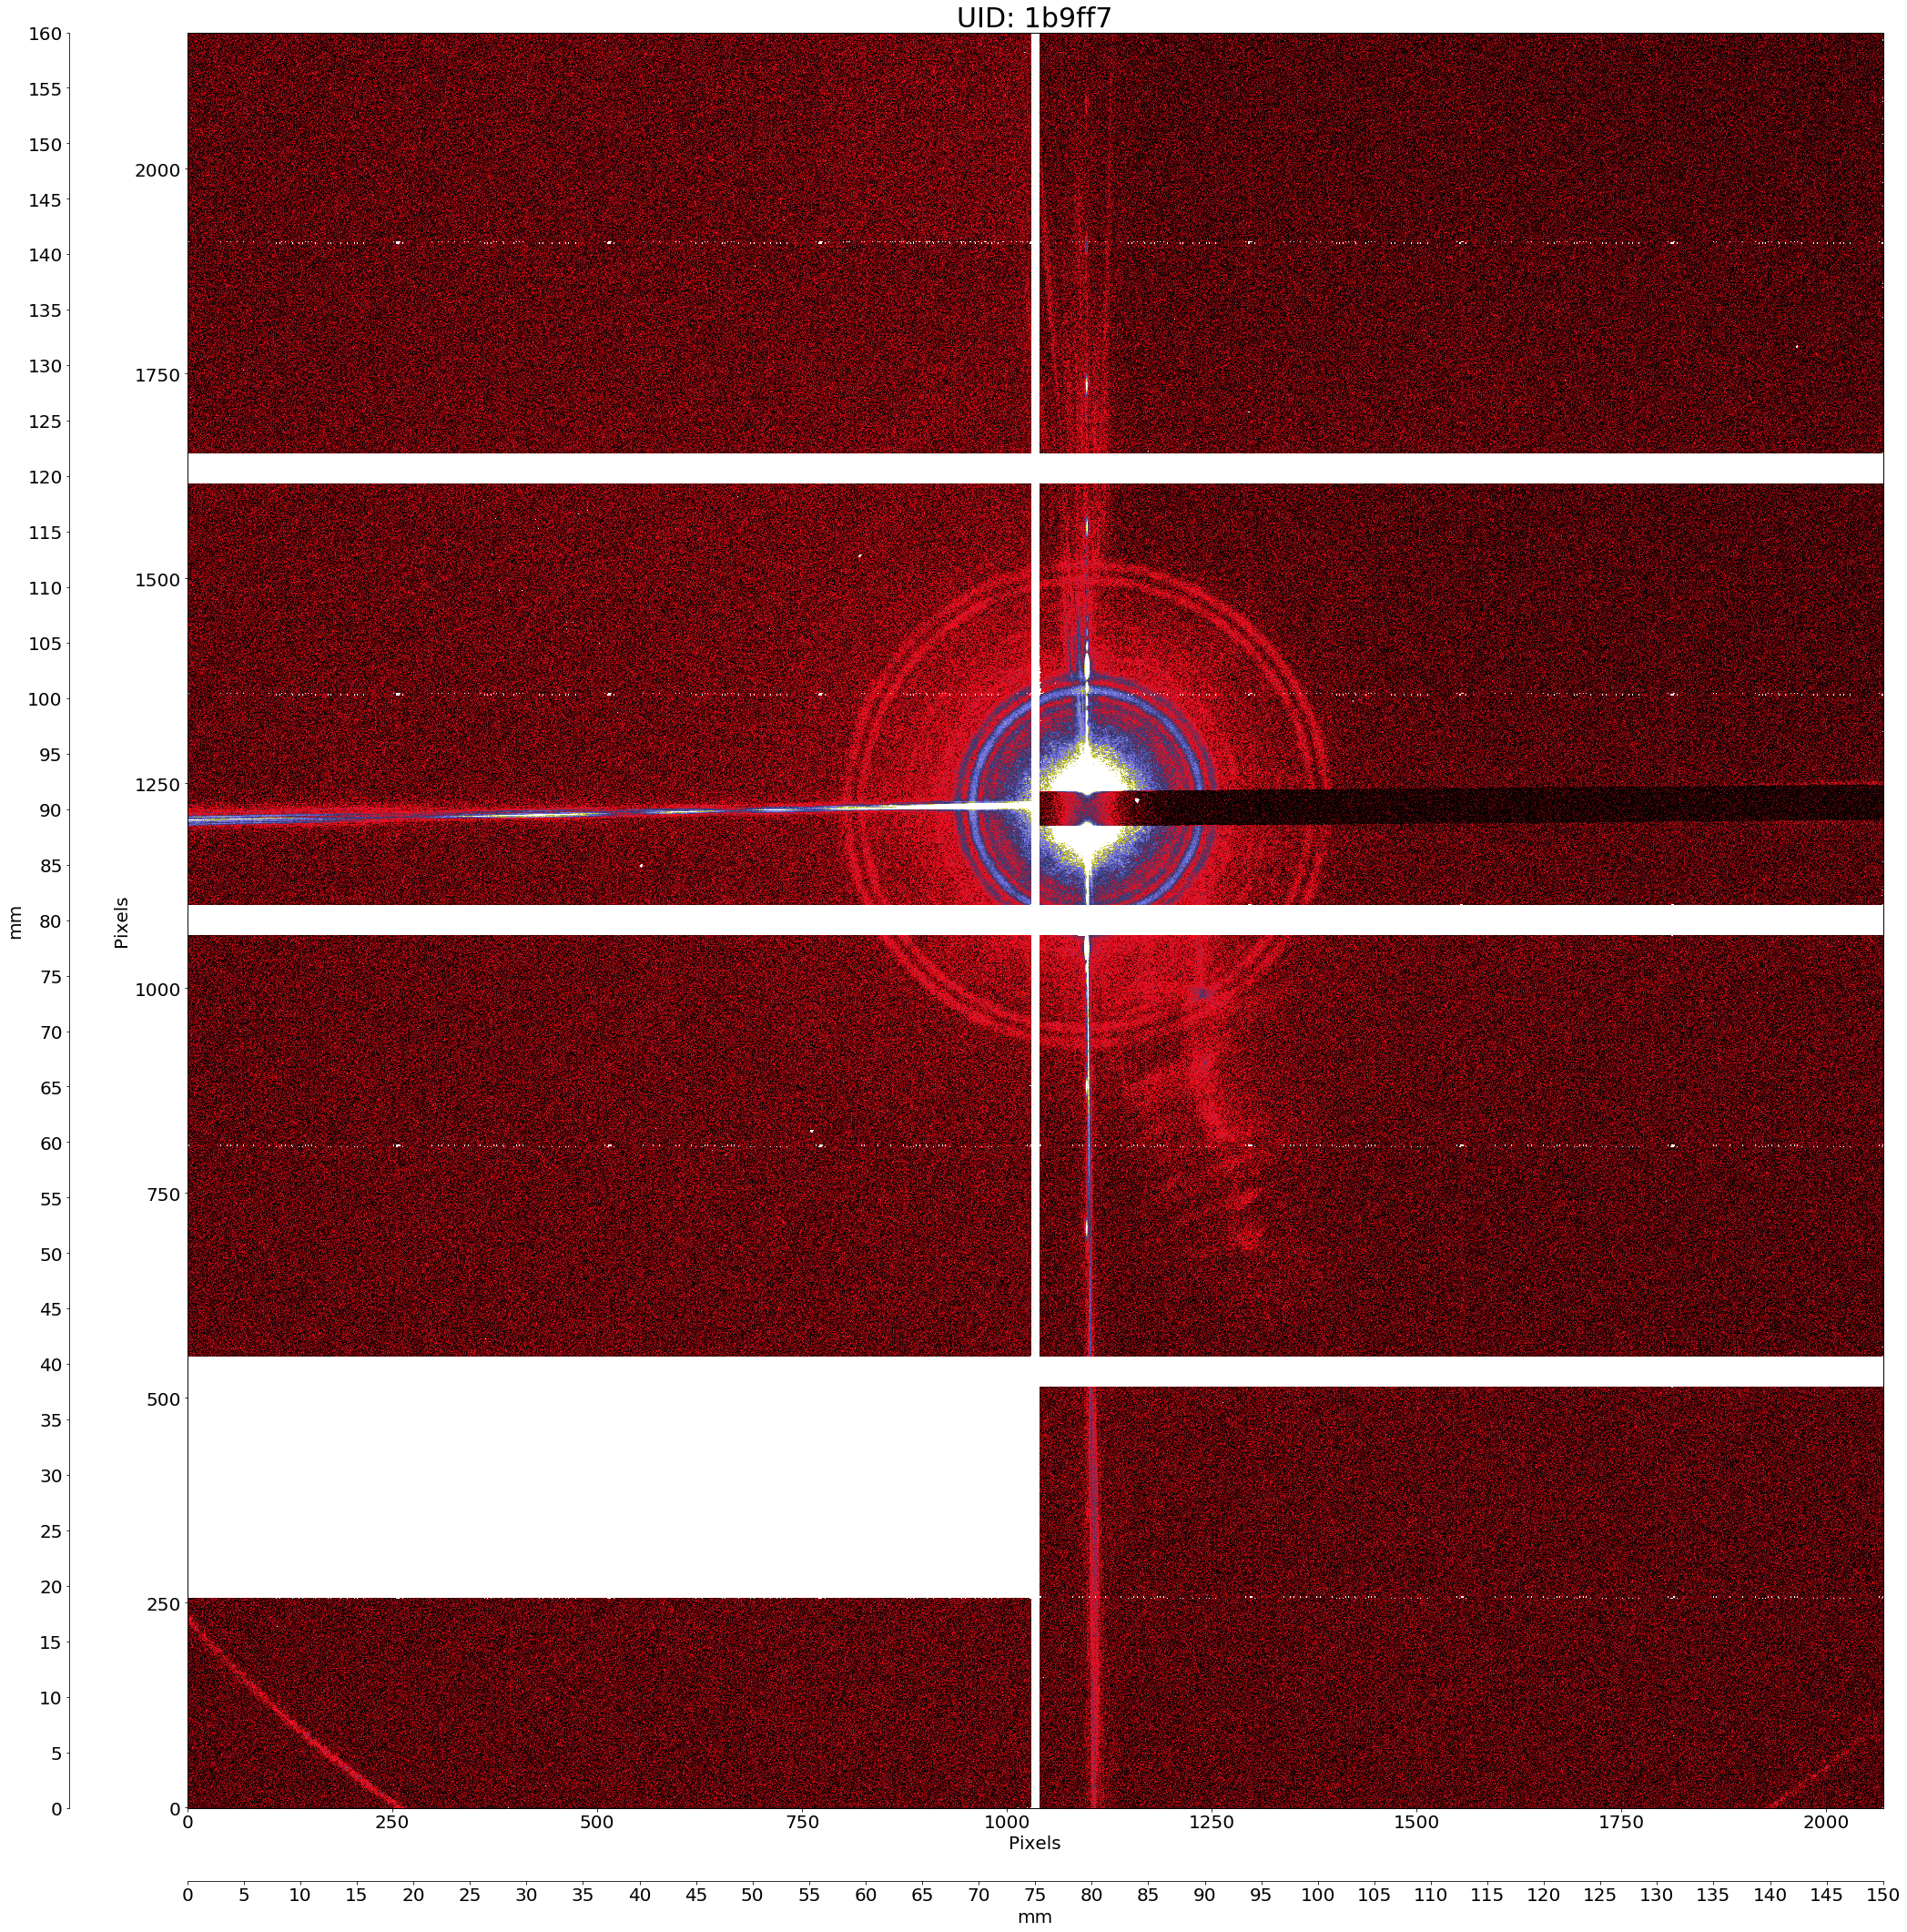

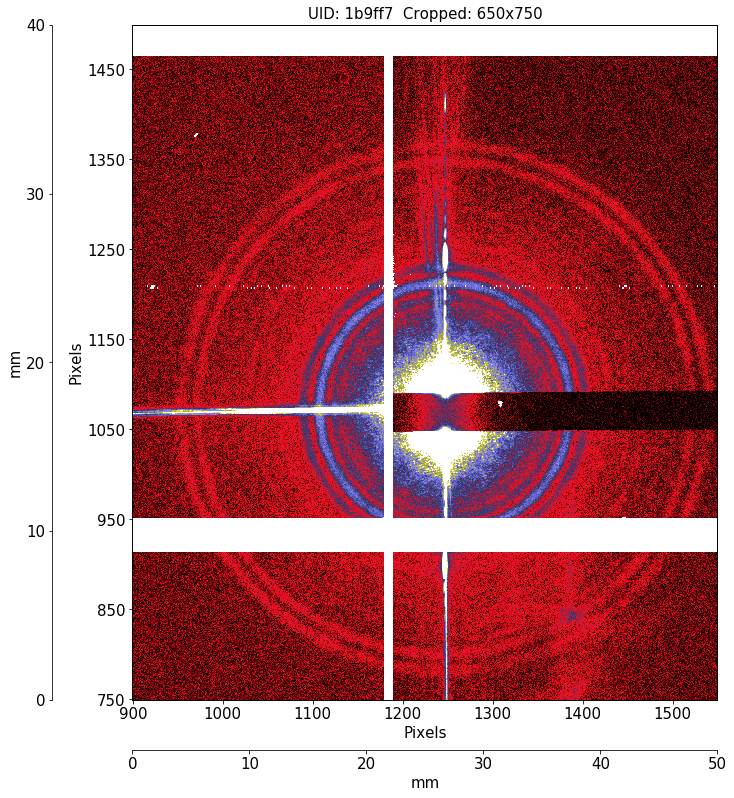



Horizontal cut at row 1200


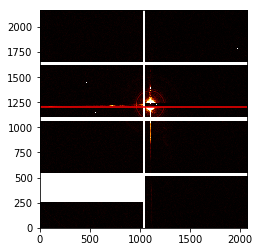

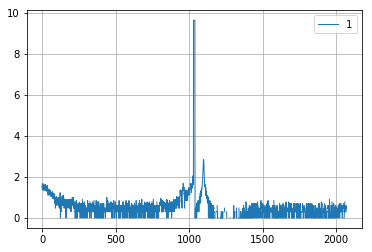



Vertical cut at column 1100


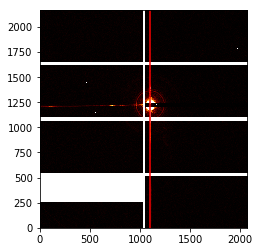

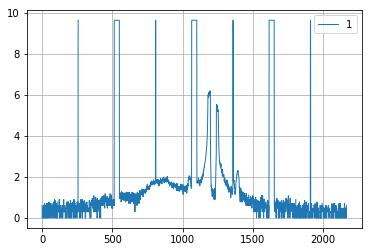

[<Frames>
 Length: 1 frames
 Frame Shape: 2167 x 2070
 Pixel Datatype: uint32]

In [445]:
plot_eiger('1b9ff7', cmap='gist_stern', frame_num=0)